In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from ipywidgets import FloatLogSlider, FloatSlider, interactive, Dropdown
from tqdm.notebook import tqdm

from generators import GCL, LXM

import simpy
import scipy

sns.set() 

# Trabajo Práctico N°2
El presente trabajo práctico fue realizado por los alumnos:
* Anarella Nicoletta (Padrón 94551)
* Bruno Grassano (Padrón 103855)
* Ignacio Javier Mermet (Padrón 98153)
* Joaquin Gomez (Padrón 103735)

## Ejercicio 1
Basándose en los trabajos
* Performance Modelling of Imaging Service or Earth Observation Satellites with Two-dimensional Markov Chain
* Queuing theory application in imaging service analysis for small Earth observation satellites

Se pide implementar las soluciones propuestas por los autores utilizando Cadenas de Markov, y Teoría de Colas, 
considerando:
1. Utilizar el generador de números al azar implementado en el Trabajo Práctico 1 para generar los números al azar utilizados en el ejercicio (comparar los resultados con los obtenidos si se utilizan los números al azar provistos por el lenguaje elegido)
2. Probar distintos escenarios
3. Opcional Comparar los resultados obtenidos, con los resultados que se obtendrían con un Generador Congruencial Lineal de módulo 2 32, multiplicador 1013904223, incremento de 1664525 y semilla igual a la parte entera del promedio de los números de padrón de los integrantes del grupo

<img src="images/cadena_markov.png"></img>

```python
class Satellite:
    def __init__(self, C=math.inf, K=4, μd=5, μ0=0.5, λ=2, generator = LXM()):
        """Args:
            C: Capture queue length limit.
            K: onboard storage capacity.
            μd: The download service time of an image is assumed exponentially distributed with mean 1/μ_d.
            μ0: The basic image capture service time is exponentially distributed with mean 1/μ_0
            λ: Arrival rate of new requests.
        """
```

```python
    @property
    def onboard_storage_capacity(self):
        return self.K
```

```python
    @property
    def images_on_onboard_storage(self):
        return self.m
```

```python
    @property
    def pending_requests(self):
        return self.n

```

```python
    def transition(self):
        ps = []
        nexts = []
        if 0 <= self.n < self.C and 0 <= self.m <= self.K:
            ps.append(self.λ)
            nexts.append((self.n + 1, self.m))
        if 0 < self.n <= self.C and 0 <= self.m < self.K:
            ps.append(self.n * self.μ0)
            nexts.append((self.n - 1, self.m + 1))
        if 0 <= self.n <= self.C and 0 < self.m <= self.K:
            ps.append(self.μd)
            nexts.append((self.n, self.m - 1))

        ps = np.array(ps)
        p = self.gen.generar() * ps.sum()
        try:
            self.n, self.m = nexts[np.digitize(p, np.cumsum(ps))]
        except:
            print(f"nexts={nexts} ps={ps} p={p} ps.cumsum()={ps.cumsum()} n={self.n} m={self.m}")
            raise
```

In [2]:
class Satellite:
    def __init__(self, C=math.inf, K=4, μd=5, μ0=0.5, λ=2, generator = LXM()):
        """Args:
            C: Capture queue length limit.
            K: onboard storage capacity.
            μd: The download service time of an image is assumed exponentially
                distributed with mean 1/μ_d.
            μ0: The basic image capture service time is exponentially distributed
                with mean 1/μ_0
            λ: Arrival rate of new requests.
        """
        self.K = K
        self.C = C
        self.μd = μd
        self.μ0 = μ0
        self.λ = λ
        self.n = 0
        self.m = 0
        self.gen = generator

    @property
    def onboard_storage_capacity(self):
        return self.K

    @property
    def images_on_onboard_storage(self):
        return self.m

    @property
    def pending_requests(self):
        return self.n

    def transition(self):
        ps = []
        nexts = []
        if 0 <= self.n < self.C and 0 <= self.m <= self.K:
            ps.append(self.λ)
            nexts.append((self.n + 1, self.m))
        if 0 < self.n <= self.C and 0 <= self.m < self.K:
            ps.append(self.n * self.μ0)
            nexts.append((self.n - 1, self.m + 1))
        if 0 <= self.n <= self.C and 0 < self.m <= self.K:
            ps.append(self.μd)
            nexts.append((self.n, self.m - 1))

        ps = np.array(ps)
        p = self.gen.generar() * ps.sum()
        try:
            self.n, self.m = nexts[np.digitize(p, np.cumsum(ps))]
        except:
            print(f"nexts={nexts} ps={ps} p={p} ps.cumsum()={ps.cumsum()} n={self.n} m={self.m}")
            raise

In [3]:
def explore_config(λ, μd, μ0, K, gen, n=100_000,):
    s = Satellite(λ=λ, μd=μd, μ0=μ0, K=K, generator = gen)

    history_images_on_board_storage = []
    history_pending_requests = []
    position_history = []

    for _ in tqdm(range(int(n))):
        history_images_on_board_storage.append(s.images_on_onboard_storage)
        history_pending_requests.append(s.pending_requests)
        position_history.append((s.n, s.m))

        s.transition()

    d1 = pd.Series(history_images_on_board_storage).value_counts().sort_index() / n
    d2 = pd.Series(history_pending_requests).value_counts().sort_index() / n

    f, (ax0, ax1, ax2) = plt.subplots(
        nrows=1,
        ncols=3,dpi=110,
        figsize=(18, 6),
        gridspec_kw={"width_ratios": [1, 1, 2]},
    )

    sns.lineplot(x=d1.index, y=d1.values, ax=ax0, linestyle="--")
    sns.scatterplot(x=d1.index, y=d1.values, ax=ax0, linestyle="--")
    ax0.set_title("Images on board")
    ax0.set_ylabel("# times")
    ax0.set_xlabel("# images on board")

    sns.lineplot(x=d2.index, y=d2.values, ax=ax1, linestyle="--")
    sns.scatterplot(x=d2.index, y=d2.values, ax=ax1, linestyle="--")
    ax1.set_title("Pending requests")
    ax1.set_ylabel("# times")
    ax1.set_xlabel("# pending requests")

    m = (
        pd.DataFrame(
            {
                "n": [x[0] for x in position_history],
                "m": [x[1] for x in position_history],
            }
        )
        .assign(v=1)
        .pivot_table(index="n", columns="m", values="v", aggfunc="sum", fill_value=0)
        / n
    )
    sns.heatmap(m, ax=ax2, square=False, fmt=".4f", annot=True)
    ax2.set_title("Steady point probabilities")

    f.suptitle(f"N={n}  $\lambda$={λ}  $\mu_d$={μd}  $\mu_0$={μ0}  K={K}  gen={type(gen).__name__}")

    plt.show()

In [4]:
λ_slider = FloatSlider(value=2, min=0.05, max=10, step=0.1, description="$\lambda$")
μd_slider=FloatSlider(value=5, min=0.01, max=10, step=0.01, description="$\mu_d$")
μ0_slider=FloatSlider(value=0.5, min=0.01, max=10, step=0.01, description="$\mu_0$")
K_slider=FloatSlider(value=4, min=1, max=10, step=1, description="$K$")
gen_dd=Dropdown(options=[("LXM", LXM()), ("GCL", GCL())], index=0, description="Generator to use")
n_slider=FloatLogSlider(value=10_000, base=10, min=2, max=8, step=1, description="Iterations", readout_format="d")

In [5]:
inter = interactive(explore_config,{'manual': True},λ=λ_slider,μd=μd_slider,μ0=μ0_slider,K=K_slider,gen=gen_dd,n=n_slider)
display(inter)

interactive(children=(FloatSlider(value=2.0, description='$\\lambda$', max=10.0, min=0.05), FloatSlider(value=…

<img src="./images/fig1.png"></img>

<img src="./images/fig2.png"></img>

<img src="./images/fig3.png"></img>

<img src="./images/fig4.png"></img>

## Ejercicio 2
Utilizar Simpy para simular una sección del ejercicio 1 a elección

Vamos a necesitar generar valores exponenciales, los obtenemos con la transformada inversa.

In [6]:
def exponencial(lambdaArgumento, generador):
    uniforme = generador.generar()
    return - np.log(1 - uniforme) / lambdaArgumento

Definimos el modelo del satelite y la solicitud.

```python
class Satelite:
    def __init__(self, env, servicioDescarga, lambdaArgumento, generador):
        self.env = env
        self.lambdaArgumento = lambdaArgumento
        self.generador = generador
        self.servicioDescarga = servicioDescarga
        self.largoColaEnTiempo = []
        self.tiemposDeServicio = []
        self.tiemposDeServicioAfectadosPorLaCola = []
        self.tiempoEntreArribos = []
        self.tiemposAcumulados = []
```

```python
    def atencion(self, id):
        tiempoAtencion = exponencial(self.lambdaArgumento, self.generador)
        servicio = self.servicioDescarga.request()
        yield servicio

        N = 1
        largoCola = len(self.servicioDescarga.queue)

        if largoCola != 0:
            N = largoCola
        tiempoServicio = tiempoAtencion / N

        self.largoColaEnTiempo.append(largoCola)
        self.tiemposDeServicio.append(tiempoAtencion)
        self.tiemposDeServicioAfectadosPorLaCola.append(tiempoServicio)

        yield env.timeout(tiempoServicio)
        self.servicioDescarga.release(servicio)
```

```python
class Solicitud:
    def __init__(self, env, satelite, id):
        self.env = env
        self.satelite = satelite
        self.id = id

    def tratarse(self):
        return self.satelite.atencion(self.id)
```

In [7]:
class Satelite:
    def __init__(self, env, servicioDescarga, lambdaArgumento, generador):
        self.env = env
        self.lambdaArgumento = lambdaArgumento
        self.generador = generador
        self.servicioDescarga = servicioDescarga
        self.largoColaEnTiempo = []
        self.tiemposDeServicio = []
        self.tiemposDeServicioAfectadosPorLaCola = []
        self.tiempoEntreArribos = []
        self.tiemposAcumulados = []

    def atencion(self, id):
        tiempoAtencion = exponencial(self.lambdaArgumento, self.generador)
        servicio = self.servicioDescarga.request()
        yield servicio

        N = 1
        largoCola = len(self.servicioDescarga.queue)

        if largoCola != 0:
            N = largoCola
        tiempoServicio = tiempoAtencion / N

        self.largoColaEnTiempo.append(largoCola)
        self.tiemposDeServicio.append(tiempoAtencion)
        self.tiemposDeServicioAfectadosPorLaCola.append(tiempoServicio)

        yield env.timeout(tiempoServicio)
        self.servicioDescarga.release(servicio)

class Solicitud:
    def __init__(self, env, satelite, id):
        self.env = env
        self.satelite = satelite
        self.id = id

    def tratarse(self):
        return self.satelite.atencion(self.id)

Creamos la funcion que se va a encargar de generar las solicitudes. Estas son nuevos procesos que van a intentar usar el servicio del satelite.

A medida que van llegando de avanza el tiempo del ambiente.

In [8]:
def generarArribos(lambdaArgumento, generador, cantidadArribos, env, satelite):
    tiempoAcumulado = 0
    id = 0
    while (id < cantidadArribos):
        tiempo = exponencial(lambdaArgumento, generador)
        nuevaSolicitud = Solicitud(env, satelite, id)
        id = 1 + id
        env.process(nuevaSolicitud.tratarse())
        yield env.timeout(tiempo)

        tiempoAcumulado += tiempo
        satelite.tiemposAcumulados.append(tiempoAcumulado)
        satelite.tiempoEntreArribos.append(tiempo)

Establecemos las configuraciones iniciales y ya podemos simular...

In [9]:
env = simpy.Environment()
def explorarSimulacion(lambdaArribos, lambdaServicio, generador, cantidadArribos=100_000):
    servicioDescarga = simpy.Resource(env, capacity=1)
    satelite = Satelite(env,servicioDescarga,lambdaServicio,generador)

    env.process(generarArribos(lambdaArribos, generador, cantidadArribos, env, satelite))

    env.run()

    f, axis = plt.subplots(
        nrows=2,
        ncols=3,
        dpi=100,
        figsize=(24, 8),
        gridspec_kw={"width_ratios": [1, 1, 2]},
    )

    axis[0,0].set_title("Densidad del tiempo entre arribos")
    p = sns.kdeplot(satelite.tiempoEntreArribos,cut=0,ax=axis[0,0])


    axis[0,1].step(satelite.tiemposAcumulados,range(len(satelite.tiemposAcumulados)),where= 'post' ,label='λ=' + str(lambdaArribos))
    axis[0,1].legend()
    axis[0,1].set_title("Arribos a lo largo del tiempo - Poisson")


    axis[0,2].set_title("Comportamiento del largo de la cola")
    p = sns.kdeplot(satelite.largoColaEnTiempo,cut=0,ax=axis[0,2])

    x,y = p.get_lines()[0].get_data()

    cdf = scipy.integrate.cumtrapz(y, x, initial=0)
    medio = np.abs(cdf-0.5).argmin()

    x_mediana = x[medio]
    y_mediana = y[medio]

    axis[0,2].vlines(x_mediana, 0, y_mediana)
    axis[0,2].set_title("Comportamiento del largo de la cola")
    axis[0,2].set_xlabel("Largo de la cola")
    axis[0,2].set_ylabel("Probabilidad")

    axis[1,0].set_title("Densidad del tiempo de servicio")
    p = sns.kdeplot(satelite.tiemposDeServicio,cut=0, ax=axis[1,0])


    axis[1,1].set_title("Densidad del tiempo de servicio afectada por la cola")
    p = sns.kdeplot(satelite.tiemposDeServicioAfectadosPorLaCola,cut=0,ax=axis[1,1])

    f.suptitle(f"N={cantidadArribos}  $\lambda$ arribos={lambdaArribos}  $\lambda$ servicio={lambdaServicio} gen={type(generador).__name__}")

    plt.show()

In [10]:
lambdaArribos_slider=FloatSlider(value=2, min=0.1, max=20, step=0.1, description="λ Arribos")
lambdaServicio_slider=FloatSlider(value=0.5, min=0.1, max=40, step=0.1, description="λ Servicio")
cantidadArribos_slider=FloatLogSlider(value=10_000, base=10, min=2, max=8, step=1, description="Solicitudes", readout_format="d")
generador_dd=Dropdown(options=[("LXM", LXM()), ("GCL", GCL())], index=0, description="Generador")

In [11]:
interSimulacion = interactive(explorarSimulacion, {'manual': True}, lambdaArribos=lambdaArribos_slider, lambdaServicio=lambdaServicio_slider, cantidadArribos=cantidadArribos_slider, generador=generador_dd)
display(interSimulacion)

interactive(children=(FloatSlider(value=2.0, description='λ Arribos', max=20.0, min=0.1), FloatSlider(value=0.…

![](images/fig5.png)

![](images/fig6.png)

![](images/fig7.png)

![](images/fig8.png)

## Ejercicio 3

Un servidor recibe solicitudes las cuales son procesadas de una por vez en el orden de llegada (política FIFO).
Se determinó que en 10 milisegundos existe una probabilidad 𝑝 = 1/40 que llegue una nueva solicitud y una probabilidad 𝑞 = 1/30 que una solicitud termine de ser procesada y deje el sistema. 
Se desea estudiar la cantidad de solicitudes en el servidor considerando tanto las que están en cola esperando ser
procesadas como la solicitud que está siendo procesada.
1. Determine la matriz de transición de estados explicando cómo se obtiene la misma.
2. Utilizando Matlab, Octave o Python simule la evolución del sistema a lo largo de 1.000 segundos. Suponga que el
sistema puede tener como máximo 30 estados posibles y que el servidor comienza sin estar procesando solicitudes.
3. Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.
4. Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado.
5. Determine el % de tiempo que el servidor se encuentra sin procesar solicitudes.

### Matriz de transición de estados

Para resolver este ejercicio vamos a definir 2 eventos independientes entre sí:

    A: arriba al sistema una nueva solicitud
    E: una solicitud es procesada y egresa del sistema

Esto nos permitirá descomponer a los estados del servidor dependiendo de cuántas solicitudes se estén procesando. La matriz de transición de estados quedaría entonces:

    M = | P0->0   P0->1   P0->2   P0->3  P0->4  ... |
        | P1->0   P1->1   P1->2   P1->3  P1->4  ... |
        | P2->0   P2->1   P2->2   P2->3  P2->4  ... |
        |  ...     ...     ...     ...    ...   ... |

Sabemos que:

    P(A) = p = 1/40
    P(E) = q = 1/30
    r = P(~A) = 1-P(A) = 1-1/40 = 39/40
    s = P(~E) = 1-P(E) = 1-1/30 = 29/30

Si hay solicitudes pendientes:
- La probabilidad que en el próximo estado haya una solicitud **menos** es r*q
- La probabilidad que en el próximo estado haya una solicitud **más** es p*s
- La probabilidad de quedar **igual** es r*s+p*q

Si no hay solicitudes pendientes:
- La probabilidad que en el próximo estado haya una solicitud **más** es p
- La probabilidad de quedar **igual** es r

Entonces, podemos reescribir la matriz de transición de estados como:
    
    M = |   r       p       0       0      0    ... |
        |  r*q   r*s+p*q   p*s      0      0    ... |
        |   0      r*q    r*s+p*q  p*s     0    ... |
        |  ...     ...     ...     ...    ...   ... |

### Simulación con 1.000 segundos suponiendo que no hay solicitudes por procesar al comienzo

In [12]:
N = 1000000  # 1.000 segundos en intervalos de 10 milisegundos

solicitudes_en_proceso = 0
estados = []
for i in range(N):
    # Agrego estado a log
    estados.append(solicitudes_en_proceso)

    # probabilidad de terminar una solicitud en proceso
    if solicitudes_en_proceso > 0 and np.random.rand() < 1.0/30:
        solicitudes_en_proceso = solicitudes_en_proceso - 1

    # probabilidad de que ingrese una solicitud nueva
    if np.random.rand() < 1.0/40:
        solicitudes_en_proceso = solicitudes_en_proceso + 1

Procedemos a graficar la cantidad de solicitudes en el servidor en función del tiempo.

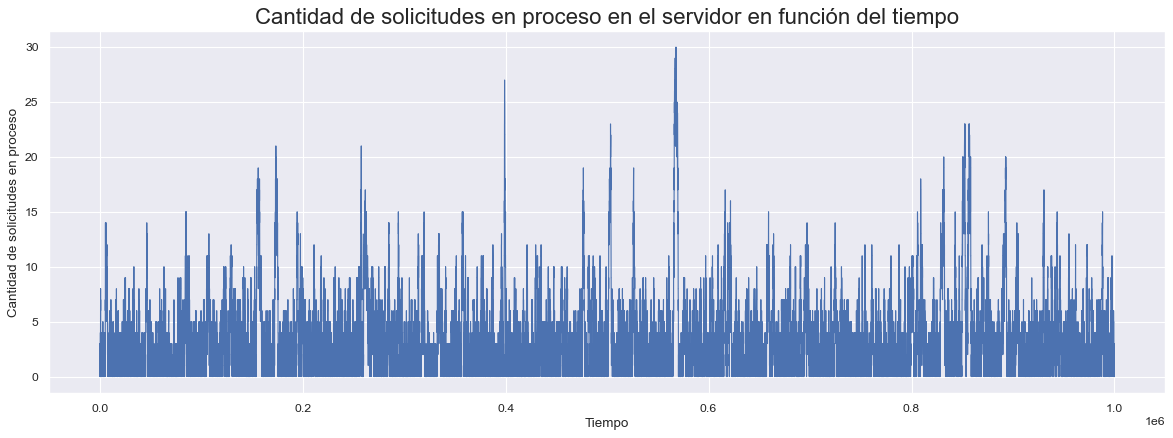

In [13]:
plt.figure(figsize=(18, 6), dpi=80)
plt.title('Cantidad de solicitudes en proceso en el servidor en función del tiempo'.format(N), size=20)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de solicitudes en proceso')
plt.plot(estados, linewidth=1.0)
plt.show()

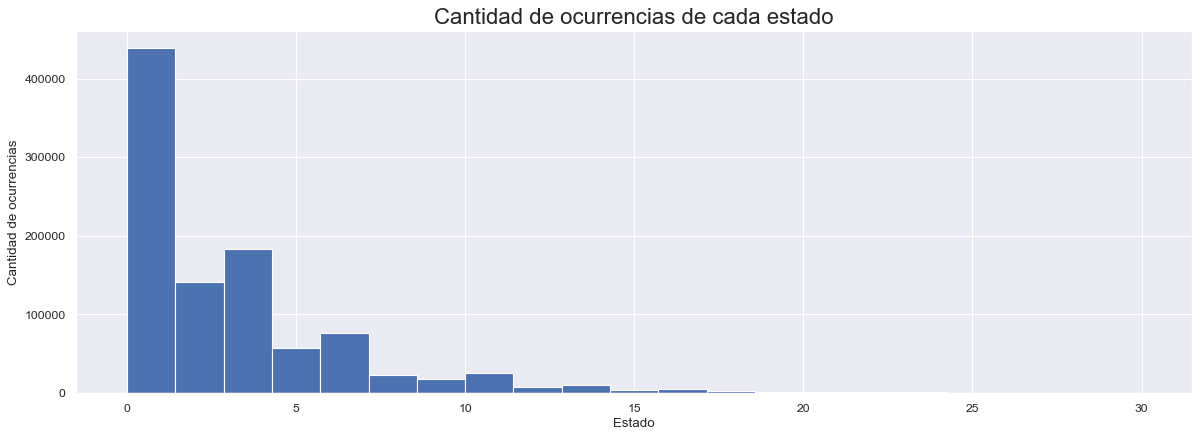

In [14]:
plt.figure(figsize=(18, 6), dpi=80)
plt.title('Cantidad de ocurrencias de cada estado'.format(N), size=20)
plt.xlabel('Estado')
plt.ylabel('Cantidad de ocurrencias')
plt.hist(estados, bins='sturges', linewidth=1.0, )
plt.show()

Procedemos ahora a analizar el tiempo ocioso del servidor, es decir, el porcentaje de tiempo durante el cual no está procesando solicitudes.

In [15]:
tiempo_sin_procesar_solicitudes = len(list(filter(lambda x: x == 0, estados))) / len(estados) * 100
'El porcentaje de tiempo que el sistema pasa sin procesar solicitudes es {:.3f} %'.format(
    tiempo_sin_procesar_solicitudes)

'El porcentaje de tiempo que el sistema pasa sin procesar solicitudes es 25.399 %'

Si revisamos desde la teoría de colas, el modelo corresponde con un M/M/1 donde $\lambda=\frac{1}{40}$ y $\mu=\frac{1}{30}$.

Lo pedido corresponde con $P(0)$, donde podemos usar que $P(0) = 1 - \rho = 1 - \frac{1/40}{1/30} = 0,25$, viendo asi que lo practico se acerca a lo teórico.


# ¿Preguntas?